<table>
  <tr>
    <td><img src="https://github.com/rvss-australia/RVSS/blob/main/Pics/RVSS-logo-col.med.jpg?raw=1" width="400"></td>
    <td><div align="left"><font size="30">Finding fiducial markers</font></div></td>
  </tr>
</table>

(c) Peter Corke 2024

Robotics, Vision & Control: Python, see section 13.6.1

## Configuring the Jupyter environment
We need to import some packages to help us with linear algebra (`numpy`), graphics (`matplotlib`), and machine vision (`machinevisiontoolbox`).
If you're running locally you need to have these packages installed.  If you're running on CoLab we have to first install machinevisiontoolbox which is not preinstalled, this will be a bit slow.

In [11]:
try:
    import google.colab
    print('Running on CoLab')
    !pip install machinevision-toolbox-python
    COLAB = True
except:
    COLAB = False

%matplotlib inline

import numpy as np
import math
from spatialmath import SE3, SO3
from spatialmath.base import e2h, h2e
from machinevisiontoolbox import Image, CentralCamera
from spatialmath.base import plot_point
import matplotlib.pyplot as plt


***

Fiducial markers are an effective way to mark points in the environment.  The markers carry a numerical identity and their position, or even pose, with respect to the camera can be determined.

This example uses OpenCV function which are available via the Machine Vision Toolbox.  Two common types of fiducual markers are used in robotics and vision: ApriTags (not covered here) and arUco markers.

## ArUco markers

ArUco markers were developed as a simple way to mark things for augmented reality (AR) applications, hence the AR in their name.  They are just high-contrast grids that encode a number as well as position and orientation.

We will load a synthetic image of some arUco markers in the lab.

libpng warning: iCCP: known incorrect sRGB profile


Image: 1920 x 1280 (uint8), B:G:R [.../images/lab-scene.png]


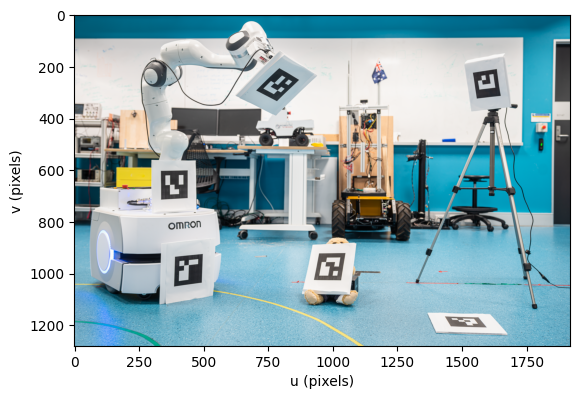

In [12]:
scene = Image.Read("lab-scene.png", rgb=False)
scene.disp();
print(scene)

We are attempting to determine the 3D pose of the arUco markers based on 2D image information, so we need to know some parameters of the imaging geometry.  We create a model of a central projection camera, using as many of the parameters as we know:
-  the focal length, in this case 4.25mm
-  the image size
- the principal point, where the optical axis passes through the image plane
- the pixel size, in this case 1.4μm

From the camera model we can derive the intrinsic parameter matrix

In [13]:
camera = CentralCamera(f=4.25e-3, imagesize=(4032, 3024), pp=(2016, 1512), rho=1.4e-6)
camera.K

array([[3.03571429e+03, 0.00000000e+00, 2.01600000e+03],
       [0.00000000e+00, 3.03571429e+03, 1.51200000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

There are many different arUco marker families, here we are using `4x4_1000` which is a $4 \times 4$ grid of squares that can encode numbers from 0 to 9999.  We pass in the marker family, the camera intrinsic parameter matrix, and the side length of the marker.  This last parameter is important, because with perspective projection we cannot tell the difference between some large and distance or small and close.  Knowing the size help us estimate distance.

In [14]:
markers = scene.fiducial("4x4_1000", K=camera.K, side=67e-3);

The return is a list of Marker objects, each has the id of the marker, and the coordinates of four corners which is enough to estimate the orientation of the planar marker in 3D , which is shown above.  We pick element 2 of the marker list  

In [15]:
marker = markers[2]
marker.id

5

which is the marker with `id` of 5, the marker being held by the teddy bear.  The corners of this particular fiducial are

In [16]:
marker.corners

array([[ 947., 1048., 1031.,  927.],
       [ 922.,  921., 1025., 1024.]], dtype=float32)

and we can display them on the original image (zoomed in)

(1200.0, 800.0)

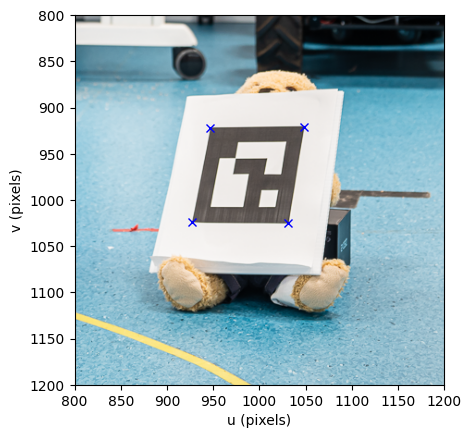

In [17]:
scene.disp(block=None)
plot_point(marker.corners, 'bx')
plt.xlim(800, 1200)
plt.ylim(1200, 800)

The pose of the fiducial, with respect to the camera, as an SE(3) matrix is

In [18]:
marker.pose

   0.9811    0.08137  -0.1755   -0.6158    
   0.03359  -0.9651   -0.2597   -0.323     
  -0.1905    0.2489   -0.9496    1.819     
   0         0         0         1         


Finally, we can render a coordinate frame associated with the pose of each fiducial, into the original image.  The fiducial's z-axis is normal to its plane.

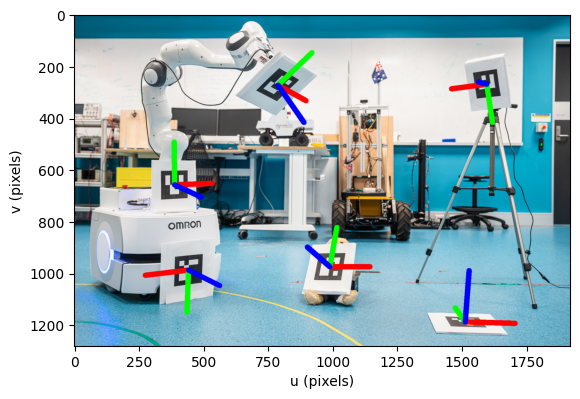

In [19]:
for marker in markers:
    marker.draw(scene, length=0.10, thick=20)
scene.disp();